## <b>Document scanner + target word recognizer</b>

In this notebook we introduce:

- scanner for documents: plug photo of your document and get scan in pdf format
- target word recognizer: detect document on photo, search target words in text and draw bounding box for them

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_local
from imutils import resize
from PIL import Image

Auxiliary functions for detection

In [2]:
DOC_COLOR_LOWER = (127, 127, 127)
DOC_COLOR_UPPER = (240, 240, 240)


def doc_threshold(image, white=True):
    if white:
        mask = cv2.inRange(image, DOC_COLOR_LOWER, DOC_COLOR_UPPER)
        image = cv2.bitwise_and(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), mask)
    else:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gaussian = cv2.GaussianBlur(image, (3, 3), cv2.BORDER_DEFAULT)
    _, thresh = cv2.threshold(gaussian, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    return thresh


def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def four_point_transform(image, pts):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    width1 = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    width2 = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    max_width = max(int(width1), int(width2))
    height1 = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    height2 = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    max_height = max(int(height1), int(height2))
    dst = np.array([
        [0, 0],
        [max_width - 1, 0],
        [max_width - 1, max_height - 1],
        [0, max_height - 1]], dtype="float32")
    transform = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, transform, (max_width, max_height))
    return warped

### Document detector

In [3]:
# document detector
def detect_document(image, pdfname="document.pdf", binarize=True, white=True):
    if pdfname.count('.pdf') != 1:
        raise Exception("Use proper name with .pdf extension for your document or choose default one")
    orig = image.copy()
    gray = cv2.cvtColor(orig, cv2.COLOR_BGR2GRAY)
    ratio = 1 #image.shape[0] / 1000.
    # resized = resize(image, height=1000)
    # resized = image.copy()
    thresh = threshold(image.copy(), white=white)
    # plt.figure(dpi=150)
    # plt.imshow(thresh, cmap='gray');
    
    cnts, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:7]

    screenCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            screenCnt = approx
            break
    if screenCnt is None:
        raise Exception("Not able to detect edges")
    
    # cv2.drawContours(resized, [screenCnt], -1, (0, 255, 0), 2)
    # plt.figure(dpi=150)
    # plt.imshow(resized, cmap='gray');

    warped = four_point_transform(gray, screen_cnt.reshape(4, 2))
    if warped.shape[0] < warped.shape[1]:
        warped = warped.T
    # plt.figure(dpi=150)
    # plt.imshow(warped, cmap='gray');
    img_warped = Image.fromarray(warped)
    img_warped.save(pdf_path)

    thresh_local = threshold_local(warped, 7, offset=7, method="gaussian")
    binarized = (warped > thresh_local).astype("uint8") * 255
    # white border
    border_x, border_y = (0.02 * np.array(binarized.shape)).astype(int)
    border = np.ones((binarized.shape[0] - 2 * border_x, binarized.shape[1] - 2 * border_y))
    border = np.pad(border, ((border_x, border_x), (border_y, border_y)))
    binarized = np.uint8(binarized + 255 * (1 - border))
    # plt.figure(dpi=150)
    # plt.imshow(binarized, cmap='gray');

    if binarize:
        pdf_path = pdf_path.rsplit('.', 1)
        pdf_path = pdf_path[0] + '_bin.' + pdf_path[1]
        img_binarized = Image.fromarray(binarized)
        img_binarized.save(pdf_path)
    return warped, binarized

### Text recognizer

Driven on tesseract, install files first

In [5]:
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract
!wget https://github.com/tesseract-ocr/tessdata/raw/master/rus.traineddata -O /usr/share/tesseract-ocr/4.00/tessdata/rus.traineddata

import string
import pytesseract

In [6]:
# specify target words
TARGET_WORDS = ['подпись', 'подлись', 'лодлись' 'подпиеь']
# set minimal edit distance between words
MIN_TARGET_DIST = 5


def ED(s, t):
    s = ' ' + s
    t = ' ' + t
    D = [[0 for j in range(len(s))] for i in range(len(t))]
    for i in range(len(s)):
        D[0][i] = i
    for i in range(len(t)):
        D[i][0] = i

    for i in range(1, len(t)):
        for j in range(1, len(s)):
            if t[i] == s[j]:
                D[i][j] = min(D[i - 1][j - 1], D[i - 1][j] + 1, D[i][j - 1] + 1)
            else:
                D[i][j] = min(D[i - 1][j - 1] + 1, D[i - 1][j] + 1, D[i][j - 1] + 1)
    return D[-1][-1]


def ind_of_sign(words):
    m = float('inf')
    w = ''
    ind = -1
    for index, s in enumerate(words):
        s = str(s).lower()
        s = s.translate(str.maketrans('', '', string.punctuation))
        dist = min([ED(i, s) for i in TARGET_WORDS])
        if dist < m:
            m = dist
            ind = index
            w = s
    if m > MIN_TARGET_DIST:
        return -1
    return ind


def get_box_from(document):
    df = pytesseract.image_to_data(document, lang='rus', output_type=pytesseract.Output.DATAFRAME)
    df = df[df['conf']!=-1]
    df = df[~df['text'].isna()]
    ind = ind_of_sign(df['text'])
    if ind == -1:
        raise Exception("None of target words is found in text")
    row = df.iloc[ind]
    return ((row['left']-10, row['top']-10), (row['left']+ row['width']+10, row['top']+row['height']+10))


def draw_sign_box(image, pdfname="document.pdf", pdfname_box="document_box.pdf"):
    try:
        doc, doc_bin = detect_document(image, pdfname)
        doc_bin = doc_bin.copy()
        box = get_box_from(doc_bin)
        img_w_sign_box = Image.fromarray(cv2.rectangle(doc_bin, *box, (0, 255, 255), 5))
        img_w_sign_box.save(pdfname_box)
        return img_w_sign_box
    except Exception as e:
        print("Not able to convert to pdf, please take a better photo")
        box = get_box_from(image)
        return cv2.rectangle(image.copy(), *box, (0, 255, 255), 5)

Test functions

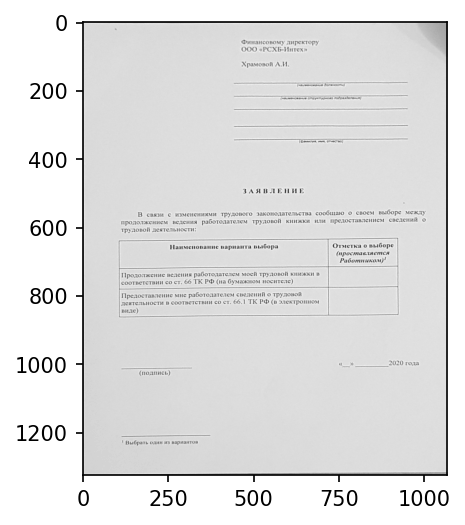

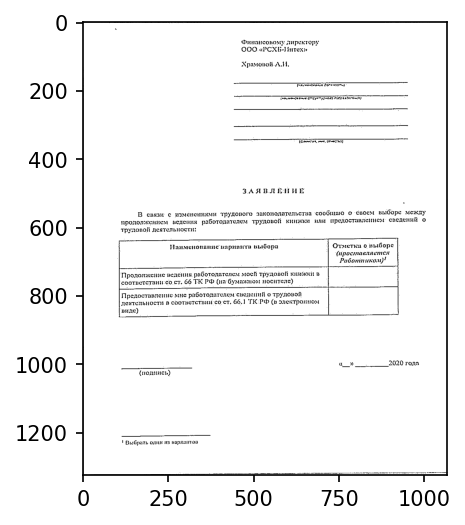

In [8]:
img = cv2.imread("./inputs/sample_1.jpg")

warped, binarized = detect_document(img)
boxed = draw_sign_box(img)

# warped document
plt.figure(dpi=150)
plt.imshow(warped, cmap='gray');
# warped and binarized document
plt.figure(dpi=150)
plt.imshow(binarized, cmap='gray');
# # added box for target word
plt.figure(dpi=150)
plt.imshow(boxed, cmap='gray');